This notebook contains the speed calculation algorithm applied for a single object (vehicle).

In [2]:
"""
Created on Thu Nov  3 10:11:45 2022

@author: kjayamanna
"""
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from tqdm import tqdm
from sklearn import linear_model
import pandas as pd
from math import sqrt

In [3]:
# REFERENCE: https://www.carwow.co.uk/guides/glossary/what-is-a-car-wheelbase-0282
WHEEL_BASE = 2.43 #IN METERS
DISTANCE_ERROR_THRESHOLD = 5

In [4]:
f = open("/code/data/datasets/common_hall/tracking_outputs/framewise_aggregation.json")
frame_to_predictions_map = json.load(f)
f = open("/code/data/datasets/common_hall/tracking_outputs/objectwise_aggregation.json")
objects_to_predictions_map = json.load(f)['annotations'] #the object_id attribute of frame_to_predictions_map are the keys of object_to_predictions_map

In [5]:
#get all the backtire keypoints for object 0
tire_dict = {}
for i in range(len(objects_to_predictions_map)):    
    tire_dict[f'obj_{i}_back_x'] = []
    tire_dict[f'obj_{i}_back_y'] = []
    tire_dict[f'obj_{i}_front_x'] = []
    tire_dict[f'obj_{i}_front_y'] = []
col_names = list(tire_dict.keys())

In [6]:
def validate_inclusion(_x, _y, _cx, _cy, _r):
    return (_x - _cx)**2 + (_y -_cy)**2 < _r**2

In [7]:
frame_path = '/code/data/datasets/frame_imgs'
frame_list = os.listdir(frame_path)
frame_border = False
rule0 = False
rule1 = False
rule2 = False
def get_objectwise_keypoints(rule0, rule1, rule2):
    objectwise_keypoints = {}
    for i in range(len(objects_to_predictions_map)):
        objectwise_keypoints[objects_to_predictions_map[i]['id']] = []
    for frame_idx in range(len(frame_to_predictions_map)):
        frame = cv2.imread(str(Path(frame_path)/frame_list[i]))
        if frame_border:
            img = cv2.rectangle(frame, (450, 200), (1280, 720), (0, 255, 0), thickness=4)
        objects_per_frame = frame_to_predictions_map[frame_idx]['annotations']
        for obj_idx in range(len(objects_per_frame)):
            back_tire_x = objects_per_frame[obj_idx]['keypoints'][0][0]
            back_tire_y =objects_per_frame[obj_idx]['keypoints'][0][1]
            front_tire_x = objects_per_frame[obj_idx]['keypoints'][1][0]
            front_tire_y = objects_per_frame[obj_idx]['keypoints'][1][1]
            x1, y1, x2, y2 = objects_per_frame[obj_idx]['bounding_box']
            #rule #0
            if rule0 == True:
                frame_save_path = Path('/code/data/datasets/rule0_imgs')
                if x1 < 600 or x1>= 1100:
                    back_tire_x = -100
                    back_tire_y = -100
                    front_tire_x = -100
                    front_tire_y = -100

            #rule #1
            if rule1 == True:
                frame_save_path = Path('/code/data/datasets/rule1_imgs')
                if (back_tire_y <= y1 + int((y2 - y1)/2)):
                    back_tire_x = -100
                    back_tire_y = -100
                if (front_tire_y <= y1 + int((y2 - y1)/2)):
                    front_tire_x = -100
                    front_tire_y = -100
            #rule #2
            if rule2 == True:
                frame_save_path = Path('/code/data/datasets/rule2_imgs')
                if validate_inclusion(back_tire_x, back_tire_y, front_tire_x, front_tire_y, 20):
                    if np.array(objects_per_frame[obj_idx]['keypoints_scores']).argmax() == 0:
                        front_tire_x = -100
                        front_tire_y = -100
                    else:
                        back_tire_x = -100
                        back_tire_y = -100

            # img = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
            # img = cv2.circle(img, (int(back_tire_x), int(back_tire_y)), radius=5, color=(0, 0, 255), thickness=-1) #Blue: Backtire
            # img = cv2.circle(img, (int(front_tire_x), int(front_tire_y)), radius=5, color=(255, 0, 0), thickness=-1) #Red Front tire
            # cv2.imwrite(os.path.join(frame_save_path, f'{frame_idx}.jpg'), img)
            # back_tire_x_list.append(back_tire_x)
            # back_tire_y_list.append(back_tire_y)
            # front_tire_x_list.append(front_tire_x)
            # front_tire_y_list.append(front_tire_y)
            objectwise_keypoints[objects_per_frame[obj_idx]['object_tracklet_id']].append((back_tire_x, back_tire_y, front_tire_x, front_tire_y))
    return objectwise_keypoints


In [8]:
objectwise_keypoints = get_objectwise_keypoints(True, True, True)
object_names = list(objectwise_keypoints.keys())

In [9]:
#@TODO: loop through all the objects in the video
vehicle_keypoints = objectwise_keypoints[object_names[4]]
object_name = object_names[4]

In [10]:
back_tire_x_list = []
back_tire_y_list = []
front_tire_x_list = []
front_tire_y_list = []
for keypoints_per_frame in objectwise_keypoints[object_name]:
    back_tire_x, back_tire_y, front_tire_x, front_tire_y = keypoints_per_frame
    back_tire_x_list.append(back_tire_x)
    back_tire_y_list.append(back_tire_y)
    front_tire_x_list.append(front_tire_x)
    front_tire_y_list.append(front_tire_y)

In [11]:
data = {"back_tire_x":back_tire_x_list, "back_tire_y":back_tire_y_list, "front_tire_x":front_tire_x_list, "front_tire_y":front_tire_y_list}
df = pd.DataFrame(data)
df.drop(df[df.back_tire_x < 0].index, inplace=True)
df.drop(df[df.front_tire_x < 0].index, inplace=True)
x = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [12]:
model = linear_model.LinearRegression()
model.fit(x, y)
coef = model.coef_[0]
bias = model.intercept_

In [13]:
back_tire_x_list = []
back_tire_y_list = []
front_tire_x_list = []
front_tire_y_list = []
for i in range(len(data['back_tire_x'])):
    back_tire_x = data['back_tire_x'][i]
    back_tire_y = data['back_tire_y'][i]
    front_tire_x = data['front_tire_x'][i]
    front_tire_y = data['front_tire_y'][i]
    if (back_tire_x < 0 and back_tire_y < 0) and (front_tire_x < 0 and front_tire_y < 0):
        back_tire_x_list.append(back_tire_x)
        back_tire_y_list.append(back_tire_y)
        front_tire_x_list.append(front_tire_x)
        front_tire_y_list.append(front_tire_y)
        continue
    if back_tire_x < 0:
        back_tire_x = (front_tire_y - back_tire_y * coef[1] - front_tire_x* coef[2] - bias)/coef[0]
    if back_tire_y < 0:
        back_tire_y = (front_tire_y - back_tire_x * coef[0] - front_tire_x* coef[2] - bias)/coef[1]
    if front_tire_x < 0:
        front_tire_x = (front_tire_y - back_tire_x * coef[0] - back_tire_y * coef[1] - bias)/coef[2]
    if front_tire_y < 0:
        front_tire_y = back_tire_x * coef[0] + back_tire_y * coef[1] + front_tire_x* coef[2] + bias

    back_tire_x_list.append(back_tire_x)
    back_tire_y_list.append(back_tire_y)
    front_tire_x_list.append(front_tire_x)
    front_tire_y_list.append(front_tire_y)

/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:634: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a)


Text(0.5, 0.92, 'Keypoints w.r.t to frames')

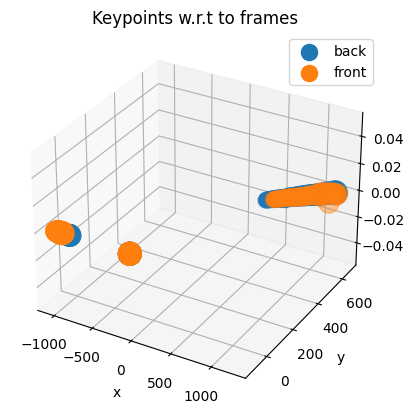

In [14]:
fig = plt.figure(1)
ax = fig.add_subplot(projection='3d')
plt.scatter(back_tire_x_list, back_tire_y_list,list(range(len(back_tire_x_list))), label ='back' )
plt.scatter( front_tire_x_list, front_tire_y_list,list(range(len(front_tire_x_list))), label='front' )
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Keypoints w.r.t to frames")

Text(0.5, 1.0, 'Before handling single keypoint cases')

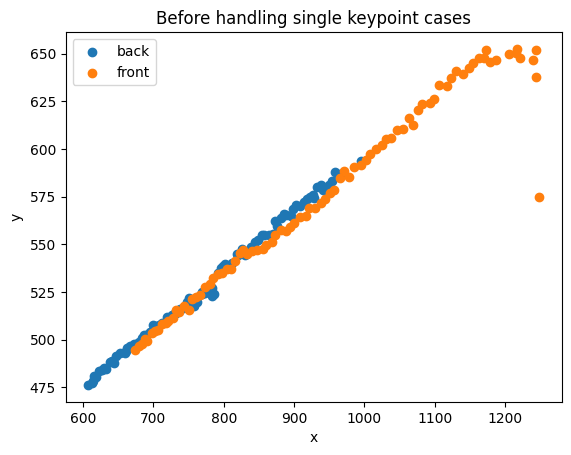

In [15]:
fig = plt.figure(2)
plt.scatter(df['back_tire_x'], df['back_tire_y'], label ='back' )
plt.scatter( df['front_tire_x'], df['front_tire_y'], label='front' )
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Before handling single keypoint cases")

/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


Text(0.5, 1.0, 'After handling single keypoint cases (Gained 50 points)')

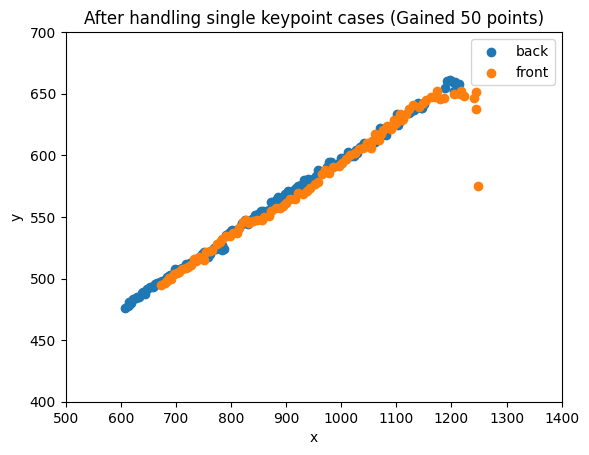

In [16]:
fig = plt.figure(3)
plt.scatter(back_tire_x_list, back_tire_y_list, label ='back' )
plt.scatter( front_tire_x_list, front_tire_y_list, label='front' )
plt.legend()
plt.xlim(500, 1400)
plt.ylim(400, 700)
plt.xlabel('x')
plt.ylabel('y')
plt.title("After handling single keypoint cases (Gained 50 points)")

In [17]:
def get_distance(_x1, _y1, _x2, _y2):
    return sqrt((_x1 -_x2)**2 + (_y1 -_y2)**2)

In [18]:
# This cell can find the average wheelbase based on complete tire sets.
# tire_distance = 0
# valid_points = 0
# total_num_points = len(objectwise_keypoints[object_name])
# for keypoints_per_frame in objectwise_keypoints[object_name]:
#     back_tire_x, back_tire_y, front_tire_x, front_tire_y = keypoints_per_frame
#     if back_tire_x >=0 and front_tire_x >=0:
#         valid_points += 1
#         tire_distance += get_distance(back_tire_x, back_tire_y, front_tire_x, front_tire_y)
# tire_distance /= valid_points
# print("Tire Distance is ", tire_distance)
# print("Num. of valid points are", valid_points)
# print("Total number of points", total_num_points)

In [19]:
def frames_to_seconds(_fps, _n_frames):
    return (1/_fps * _n_frames)

In [20]:

vehicle_speed = []
skipped = 0

back_tire_keypoints = [back_tire_x_list, back_tire_y_list]
back_tire_keypoints = [list(x) for x in zip(*back_tire_keypoints[::-1])]
front_tire_keypoints = [front_tire_x_list, front_tire_y_list]
front_tire_keypoints = [list(x) for x in zip(*front_tire_keypoints[::-1])]

back_tire_x_list = []
back_tire_y_list = []
front_tire_x_list = []
front_tire_y_list = []
speed_checkpoints = []

approximate_speed = -1
vehicle_speed = {}
total_num_points = len(objectwise_keypoints[object_name])
for i in range(total_num_points):
    back_tire = back_tire_keypoints[i]
    front_tire = front_tire_keypoints[i]
    if back_tire[0] < 0 or front_tire[0] <0:
        vehicle_speed[i] = approximate_speed
        skipped+=1
        continue
    for j in range(i,total_num_points):
        future_back_tire = back_tire_keypoints[j]
        if future_back_tire[0] < 0:
            continue
        back_tire_x = back_tire[0]
        back_tire_y = back_tire[1]
        front_tire_x = front_tire[0]
        front_tire_y = front_tire[1]
        future_back_tire_x = future_back_tire[0]
        future_back_tire_y = future_back_tire[1]
        current_keypoints_distance = get_distance(back_tire_x, back_tire_y, front_tire_x, front_tire_y)
        future_keypoints_distance = get_distance(back_tire_x, back_tire_y, future_back_tire_x, future_back_tire_y)
        if  current_keypoints_distance <= future_keypoints_distance:
            if (future_keypoints_distance - current_keypoints_distance) < DISTANCE_ERROR_THRESHOLD:
                approximate_speed = round(WHEEL_BASE / frames_to_seconds(30, j - i))
                print("Current Speed is", approximate_speed, "meters/Sec")
                vehicle_speed[i] = approximate_speed
                back_tire_x_list.append(back_tire_x)
                back_tire_y_list.append(back_tire_y)
                front_tire_x_list.append(front_tire_x)
                front_tire_y_list.append(front_tire_y)
            break
        
    



Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 4 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 3 meters/Sec
Current Speed is 2 meters/Sec
Current Speed is 2 meters/Sec
Current Speed is 2 meters/Sec
Current Sp